In [1]:
%matplotlib inline

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

import time

# __CNN on MNIST__

__Dataset__

In [7]:
transform = transforms.ToTensor()

train_data = datasets.MNIST(root = '../Data', train = True, download = True, transform = transform)
test_data = datasets.MNIST(root = '../Data', train = False, download = True, transform = transform)

In [8]:
train_loader = DataLoader(train_data, batch_size = 10, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 10, shuffle = False)

In [17]:
train_data, test_data

(Dataset MNIST
     Number of datapoints: 60000
     Root location: ../Data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: ../Data
     Split: Test
     StandardTransform
 Transform: ToTensor())

## __Layers__

In [18]:
conv1 = nn.Conv2d(1, 6, 3, 1) # color channel, number of filters (output channels), filter size (3 x 3), stride / step
conv2 = nn.Conv2d(6, 16, 3, 1) # input filters from conv1, 16 output filters, 3x3 kernel, stride = 1

In [19]:
for i, (X_train, y_train) in enumerate(train_data):
    break

In [23]:
X_train.shape # batch of 1 image

torch.Size([1, 28, 28])

In [27]:
image_x = X_train.view(1, 1, 28, 28)

In [28]:
image_x = F.relu(conv1(image_x))

In [29]:
image_x.shape

torch.Size([1, 6, 26, 26])

In [30]:
image_x = F.max_pool2d(image_x, 2, 2) # ---> 2x2 kernel, stride= 2

In [31]:
image_x.shape

torch.Size([1, 6, 13, 13])

In [32]:
image_x = F.relu(conv2(image_x))

In [33]:
image_x.shape

torch.Size([1, 16, 11, 11])

In [34]:
image_x = F.max_pool2d(image_x, 2, 2)

In [36]:
image_x.shape # 11 / 2 = 5.5 ----> rounding down hier

torch.Size([1, 16, 5, 5])

In [37]:
image_x.view(-1, 16*5*5)

tensor([[0.0000e+00, 7.5603e-02, 1.0693e-01, 7.7815e-02, 4.1972e-02, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 5.3136e-02, 0.0000e+00, 0.0000e+00, 7.5892e-03, 1.8039e-02,
         0.0000e+00, 0.0000e+00, 3.1725e-02, 6.5673e-02, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 8.3568e-02, 2.4940e-02, 7.4766e-02, 1.5545e-01, 2.9075e-01,
         9.5699e-02, 1.0407e-01, 2.3933e-01, 3.6103e-01, 2.2226e-01, 1.1467e-01,
         1.1425e-01, 1.2487e-01, 1.1507e-01, 2.2240e-01, 8.5807e-02, 9.5144e-02,
         1.0336e-01, 3.8920e-01, 3.5808e-01, 4.7867e-02, 2.2624e-01, 3.3901e-01,
         3.5645e-01, 1.9410e-01, 1.1219e-01, 1.9148e-01, 1.4904e-01, 1.4944e-01,
         1.5022e-01, 1.5624e-01, 2.5718e-01, 3.4327e-01, 2.9932e-01, 3.0256e-01,
         1.3180e-01, 1.6880e-01, 1.8904e-01, 1.6543e-01, 1.1106e-01, 1.1742e-01,
         1.7413e-01, 3.0288e-01, 2.1066e-01, 1.6277e-01, 1.7328e-01, 1.3919e-01,
         3.1047e-01, 3.3128e

In [38]:
image_x.view(-1, 16*5*5).shape

torch.Size([1, 400])

## __CNN model__

In [48]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(400, 120) # 16*5*5 = 400
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, image_x):
        image_x = F.relu(self.conv1(image_x))
        image_x = F.max_pool2d(image_x, 2, 2)
        image_x = F.relu(self.conv2(image_x))
        image_x = F.max_pool2d(image_x, 2, 2)
        image_x = image_x.view(-1, 400) # flatten to enter the fully connected layer
        image_x = F.relu(self.fc1(image_x))
        image_x = F.relu(self.fc2(image_x))
        image_x = self.fc3(image_x)
        return F.log_softmax(image_x, dim = 1)

In [49]:
torch.manual_seed(53)

cnn_model = ConvolutionalNetwork()
cnn_model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [50]:
for param in cnn_model.parameters():
    print(param.numel())

54
6
864
16
48000
120
10080
84
840
10


In [51]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr = 0.001)

## __Training__

In [52]:
start_time = time.time()

epochs = 10

train_losses = []
test_losses = []

train_correct = []
test_correct = []

for i in range(epochs):
    train_corr = 0
    test_corr = 0

    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1

        y_pred = cnn_model(X_train)
        loss = criterion(y_pred, y_train)

        predicted = torch.max(y_pred.detach(), dim = 1)[1] # values: [0.1, 0.0,..., 0.8]; indices: [0, 1,..., 9] ----> 9
        
        batch_correct = (predicted == y_train).sum()
        
        train_corr += batch_correct

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b % 100 == 0:
            accuracy = train_corr.item() * 100 / (100 * b)
            print(f"Epoch: {i}; batch: {b}; loss: {loss.item():.6f}; accuracy: {accuracy:.3f}")
        
    train_losses.append(loss)
    train_correct.append(train_corr)

    with torch.no_grad():
        
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = cnn_model(X_test)
            predicted = torch.max(y_val.detach(), 1)[1]
            test_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(test_corr)


total_time = time.time() - start_time
print(f"Duration: {total_time / 60:.3f} minutes")

Epoch: 0; batch: 100; loss: 1.222152; accuracy: 4.440
Epoch: 0; batch: 200; loss: 0.621281; accuracy: 6.165
Epoch: 0; batch: 300; loss: 0.503847; accuracy: 7.017
Epoch: 0; batch: 400; loss: 0.585247; accuracy: 7.460
Epoch: 0; batch: 500; loss: 0.382176; accuracy: 7.782
Epoch: 0; batch: 600; loss: 0.123733; accuracy: 8.023
Epoch: 0; batch: 700; loss: 0.272137; accuracy: 8.187
Epoch: 0; batch: 800; loss: 0.418517; accuracy: 8.318
Epoch: 0; batch: 900; loss: 0.083477; accuracy: 8.406
Epoch: 0; batch: 1000; loss: 0.243989; accuracy: 8.495
Epoch: 0; batch: 1100; loss: 0.015769; accuracy: 8.585
Epoch: 0; batch: 1200; loss: 0.073449; accuracy: 8.650
Epoch: 0; batch: 1300; loss: 0.178541; accuracy: 8.720
Epoch: 0; batch: 1400; loss: 0.626904; accuracy: 8.769
Epoch: 0; batch: 1500; loss: 0.026592; accuracy: 8.817
Epoch: 0; batch: 1600; loss: 0.060796; accuracy: 8.848
Epoch: 0; batch: 1700; loss: 0.061693; accuracy: 8.889
Epoch: 0; batch: 1800; loss: 0.045581; accuracy: 8.922
Epoch: 0; batch: 19

## __Evaluation__

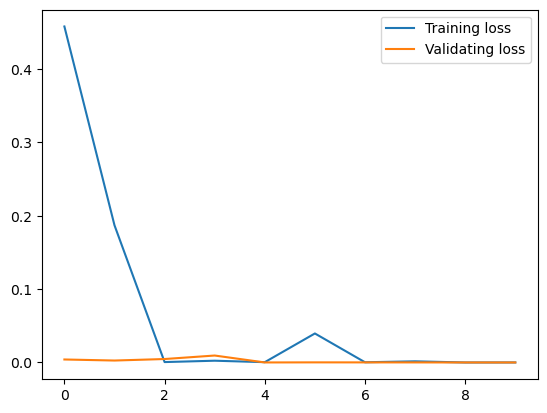

In [53]:
plt.plot([trl.detach().numpy() for trl in train_losses], label = "Training loss")
plt.plot([tsl.detach().numpy() for tsl in test_losses], label = "Validating loss")

plt.legend()
plt.show()

In [54]:
train_accuracy = [t / 600 for t in train_correct]
val_accuracy = [t / 100 for t in test_correct]

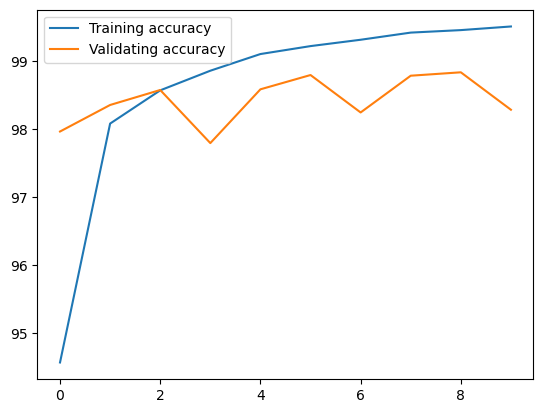

In [55]:
plt.plot(train_accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label = "Validating accuracy")

plt.legend()
plt.show()

## __Testing with new data__


In [56]:
all_data_test_load = DataLoader(test_data, batch_size = 10000, shuffle = False)

In [59]:
with torch.no_grad():
    correct = 0
    
    for X_test, y_test in all_data_test_load:
        y_testing = cnn_model(X_test)
        predicted = torch.max(y_testing.detach(), 1)[1]
        correct += (predicted == y_test).sum()


In [60]:
# total accuracy on the test dataset

correct.item() / len(test_data) * 100

98.28

In [61]:
confusion_matrix(predicted.flatten(), y_test.flatten())

array([[ 976,    1,    1,    0,    0,    1,    5,    2,    2,    3],
       [   0, 1119,    1,    0,    0,    0,    1,    3,    0,    0],
       [   0,    1, 1021,    4,    0,    1,    0,   13,    1,    0],
       [   0,    4,    0, 1000,    0,   10,    0,    1,    1,    0],
       [   0,    1,    1,    0,  965,    0,    3,    3,    0,    5],
       [   0,    1,    0,    1,    0,  872,    2,    0,    1,    5],
       [   2,    3,    3,    0,    5,    2,  946,    0,    0,    0],
       [   1,    0,    3,    0,    0,    1,    0, 1000,    0,    2],
       [   1,    5,    2,    4,    3,    5,    1,    4,  969,   34],
       [   0,    0,    0,    1,    9,    0,    0,    2,    0,  960]],
      dtype=int64)

## __Testing only one image__

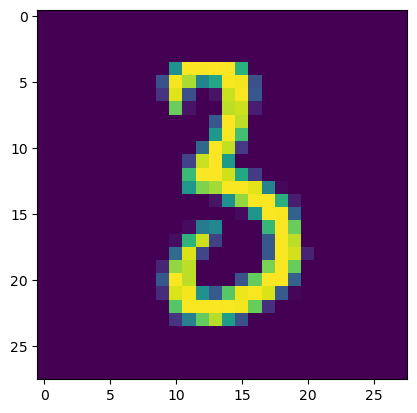

In [63]:
plt.imshow(test_data[2025][0].reshape(28, 28))

In [64]:
cnn_model.eval()
with torch.no_grad():
    new_prediction = cnn_model(test_data[2025][0].view(1, 1, 28, 28))

In [65]:
new_prediction

tensor([[-2.1069e+01, -1.6624e+01, -1.5061e+01, -1.1678e-03, -2.2749e+01,
         -9.1645e+00, -1.5655e+01, -1.9339e+01, -6.8476e+00, -1.7055e+01]])

In [66]:
new_prediction.argmax()

tensor(3)

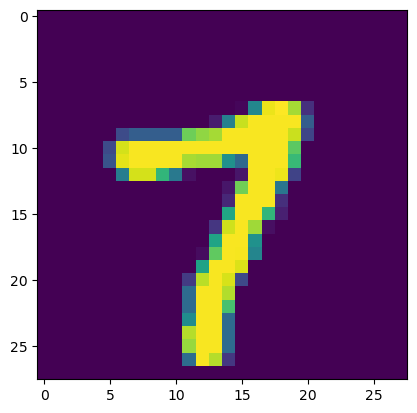

In [75]:
plt.imshow(test_data[1563][0].reshape(28, 28))

In [76]:
cnn_model.eval()
with torch.no_grad():
    new_prediction = cnn_model(test_data[1563][0].view(1, 1, 28, 28))

In [77]:
new_prediction

tensor([[-2.5858e+01, -1.5487e+01, -1.5820e+01, -1.6698e+01, -1.2647e+01,
         -2.2885e+01, -4.2483e+01, -8.3446e-06, -1.8695e+01, -1.2246e+01]])

In [78]:
new_prediction.argmax()

tensor(7)

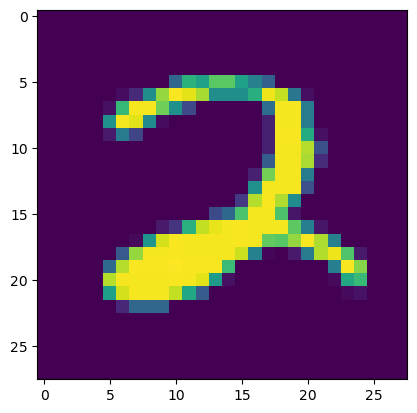

In [79]:
plt.imshow(test_data[888][0].reshape(28, 28))

In [80]:
cnn_model.eval()
with torch.no_grad():
    new_prediction = cnn_model(test_data[888][0].view(1, 1, 28, 28))

In [81]:
new_prediction

tensor([[-23.1621, -27.2245,   0.0000, -17.1081, -20.2469, -35.1046, -30.8921,
         -19.3526, -21.0239, -25.5059]])

In [82]:
new_prediction.argmax()

tensor(2)

## __Incorrect guesses__

In [83]:
incorrect = np.array([])
for i in range(len(predicted.flatten())):
    if predicted[i] != y_test[i]:
        incorrect = np.append(incorrect,i).astype('int64')
        
# the number of incorrect predictions
len(incorrect)

172

In [84]:
r = 10
batch = iter(np.array_split(incorrect,len(incorrect)//r+1))

Index: [582 593 619 646 659 717 720 726 813 881]
Label: [8 9 1 2 2 0 5 7 9 4]
Guess: [2 8 8 6 7 6 8 3 8 9]


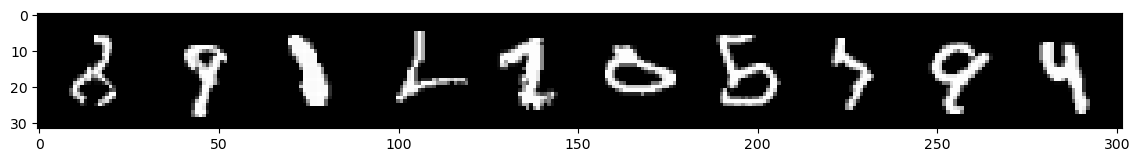

In [86]:
nextrow = next(batch)
print("Index:", nextrow)
print("Label:", y_test.index_select(0, torch.tensor(nextrow)).numpy())
print("Guess:", predicted.index_select(0, torch.tensor(nextrow)).numpy())

images = X_test.index_select(0, torch.tensor(nextrow))
im = make_grid(images, nrow = r)
plt.figure(figsize = (14, 8))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))
plt.show()